<a href="https://colab.research.google.com/github/ViniciusSevero/desafio_bemagro/blob/main/Modelo_BEMAGRO_NDVI_DataSet1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from os import listdir
from os.path import join, isdir, sep

from imutils import paths

from tqdm import tqdm

from osgeo import gdal
from collections import Counter

%matplotlib inline

from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, Xception, InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras import optimizers

import tensorflow.keras.backend as K
import copy
import cv2
import rasterio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Convertendo imagens Raster para JPG

In [ ]:
def normalize_array(arr):
  min = np.min(arr[np.nonzero(arr)])
  return ((arr - min) * (1/(arr.max() - min) * 255)).astype('uint8')

In [ ]:
def remove_bg(b1, b2, b3):
  bg_pixel_b1 = b1[0][0]
  bg_pixel_b2 = b2[0][0]
  bg_pixel_b3 = b3[0][0]

  print(bg_pixel_b1, bg_pixel_b2, bg_pixel_b3)

  new_b1 = copy.deepcopy(b1)
  new_b2 = copy.deepcopy(b2)
  new_b3 = copy.deepcopy(b3)

  for line in range(len(b1)):
    for column in range(len(b1[line])):
      if(b1[line][column] == bg_pixel_b1 and 
        b2[line][column] == bg_pixel_b2 and 
        b3[line][column] == bg_pixel_b3):
        new_b1[line][column] = 255
        new_b2[line][column] = 255
        new_b3[line][column] = 255

  return (new_b1, new_b2, new_b3)

In [ ]:
base_path = "drive/MyDrive/BEMAGRO/dataset_1/RGB/"
new_path = "drive/MyDrive/BEMAGRO/dataset_1/JPEG/"
for fileName in os.listdir(base_path):
  if('.xml' in fileName):
    continue
  dataset = gdal.Open(base_path + fileName)
  if(dataset is None):
    continue

  dataset.GetRasterBand(1).SetColorInterpretation(gdal.GCI_RedBand)
  dataset.GetRasterBand(2).SetColorInterpretation(gdal.GCI_GreenBand)
  dataset.GetRasterBand(3).SetColorInterpretation(gdal.GCI_BlueBand)

  band1 = dataset.GetRasterBand(1)
  band2 = dataset.GetRasterBand(2)
  band3 = dataset.GetRasterBand(3)

  b1 = band1.ReadAsArray()
  b2 = band2.ReadAsArray()
  b3 = band3.ReadAsArray()

  b1 = normalize_array(b1)
  b2 = normalize_array(b2)
  b3 = normalize_array(b3)

  b1, b2, b3 = remove_bg(b1,b2,b3)

  img = np.dstack((b1, b2, b3))
  image = Image.fromarray(np.uint8(img))
  outfile = fileName.split('.')[0] + '.png'
  image.save(new_path + outfile)

244 201 10
89 1 67
153 58 206
48 155 6
168 193 158
202 28 89
134 213 53
69 116 178
222 164 68
201 30 143
237 217 133
177 7 250
40 219 31
251 199 168
125 16 70
224 226 150
172 35 95
19 11 103
82 202 18
29 12 54
149 186 229
155 65 141
176 0 5
18 95 180
24 115 19
103 205 237
37 143 226
169 174 3
234 150 113
168 210 235
214 56 86
124 55 5
244 126 103
183 47 190
97 158 186
23 225 161
196 226 67
93 138 35
250 126 59
90 34 163
191 41 227
225 197 214
236 83 22
113 255 3
203 236 118
203 101 71
27 251 109
148 74 41
113 248 88
106 80 27
185 52 51
79 131 30
89 92 236
161 17 203
191 132 139
86 156 22
134 125 146
219 80 102
214 31 85
199 18 50
244 78 153
135 193 75
148 95 165
11 206 242
214 197 141
125 11 43


# Entendendo NDVI

In [ ]:
# img_path_ndvi = 'drive/MyDrive/BEMAGRO/dataset_1/NDVI/2016-04-29.tif'
# img_path_png = 'drive/MyDrive/BEMAGRO/dataset_1/JPEG/2016-04-29.png'
# img_path_ndvi = 'drive/MyDrive/BEMAGRO/dataset_1/NDVI/2017-06-03.tif'
# img_path_png = 'drive/MyDrive/BEMAGRO/dataset_1/JPEG/2017-06-03.png'
img_path_ndvi = 'drive/MyDrive/BEMAGRO/dataset_1/NDVI/2016-07-18.tif'
img_path_png = 'drive/MyDrive/BEMAGRO/dataset_1/JPEG/2016-07-18.png'
dataset = rasterio.open(img_path_ndvi)
ndvi = dataset.read()
ndvi

array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)

In [ ]:
print(np.min(ndvi))
print(np.max(ndvi))
print(ndvi[ndvi > -1].mean())
np.unique(ndvi)

-9999.0
0.74222726
0.21239887


array([-9.9990000e+03,  6.8793617e-02,  7.7115990e-02, ...,
        7.3333335e-01,  7.3619455e-01,  7.4222726e-01], dtype=float32)

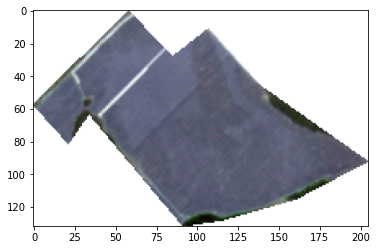

In [ ]:
img = cv2.imread(img_path_png, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap="gray")

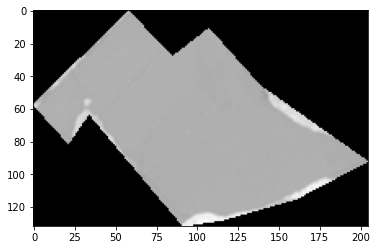

In [ ]:
part = ndvi.copy()[0]
part[part < -1] = -1
plt.imshow(part, cmap="gray")

In [ ]:
img = cv2.imread(img_path_png, cv2.COLOR_BGR2RGB)
print(img.shape)
print(ndvi.shape)

(132, 205, 3)
(1, 132, 205)


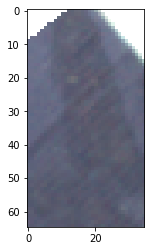

In [ ]:
part = img[15:80, 90:125]
plt.imshow(part, cmap="gray")

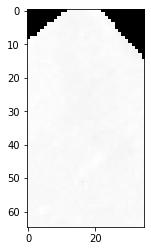

In [ ]:
part = ndvi.copy()[0][15:80, 90:125]
part[part < -1] = -1
plt.imshow(part, cmap="gray")

In [ ]:
part[10:50][10:15]

array([[0.20437956, 0.2004473 , 0.19944212, 0.20521353, 0.1998894 ,
        0.19865696, 0.20506184, 0.20453191, 0.19515151, 0.19356833,
        0.19140872, 0.18773946, 0.18466899, 0.18230648, 0.17854849,
        0.17858309, 0.18762344, 0.19033432, 0.19235836, 0.18800913,
        0.1943625 , 0.18889269, 0.18350515, 0.18112834, 0.18038076,
        0.18907036, 0.19402985, 0.1918958 , 0.19895288, 0.20417634,
        0.19534884, 0.19485079, 0.19264968, 0.18694724, 0.18779491],
       [0.20325203, 0.20033717, 0.19776224, 0.20222223, 0.20703125,
        0.20158327, 0.19520548, 0.20092915, 0.20609756, 0.2       ,
        0.1885786 , 0.18158403, 0.17793368, 0.17680429, 0.1757925 ,
        0.17785785, 0.18712674, 0.18714806, 0.1824435 , 0.17533718,
        0.17291255, 0.17533585, 0.17981714, 0.18504065, 0.18484947,
        0.18732171, 0.19280359, 0.19767442, 0.20093732, 0.19507186,
        0.1942319 , 0.19822222, 0.19539534, 0.19361901, 0.18945312],
       [0.20189627, 0.19844358, 0.19731319, 0.

## Classificando NDVI


In [ ]:
def generate_ndvi_colored(ndvi_path, rgb_path):
  img = cv2.imread(rgb_path, cv2.COLOR_BGR2RGB)
  dataset = rasterio.open(ndvi_path)
  ndvi = dataset.read()
  for idx_line, line in enumerate(img):
    for pixel_idx, pixel in enumerate(line):
      ndvi_value = ndvi[0][idx_line][pixel_idx]
      # Fundo
      if(ndvi_value < -1):
        img[idx_line][pixel_idx] = [255, 255, 255]
      # Objetos Inanimados
      elif(ndvi_value <= 0):
        img[idx_line][pixel_idx] = [0, 0, 0]
      # Plantas não saudáveis
      elif(ndvi_value <= 0.33):
        img[idx_line][pixel_idx] = [255, 0, 0]
      # Plantas moderadamente saudáveis
      elif(ndvi_value <= 0.75):
        img[idx_line][pixel_idx] = [255, 150, 51]
      # Saudáveis
      else:
        img[idx_line][pixel_idx] = [0, 255, 0]
  return img

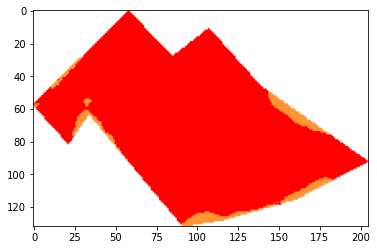

In [ ]:
img = generate_ndvi_colored(img_path_ndvi, img_path_png)
plt.imshow(img, cmap="gray")

# Calculando áreas

In [ ]:
def get_total_area_by_threshold(threshold_min, threshold_max, ndvi):
  ndvi_c = ndvi.copy()[0]
  mask = np.zeros((ndvi_c.shape[0], ndvi_c.shape[1], 3))
  cont_area = 0
  for l, line in enumerate(ndvi_c):
    for c, pixel in enumerate(line):
      if(pixel > threshold_min and pixel <= threshold_max):
        mask[l][c] = [0,0,0]
        cont_area += 1
      else:
        mask[l][c] = [255,255,255]
  return (mask, cont_area)

## Área Total

In [ ]:
img, area = get_total_area_by_threshold(-1, 1, ndvi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


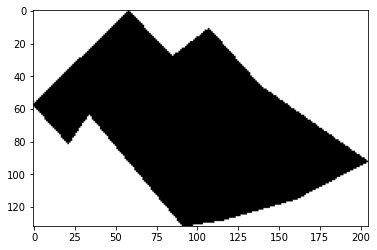

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
print('A área total é {} pixels quadrados'.format(area))

A área total é 13417 pixels quadrados


## Objetos inanimados


In [ ]:
img, area = get_total_area_by_threshold(-1, 0, ndvi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


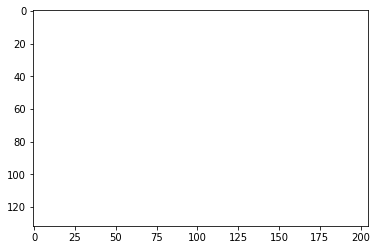

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
print('A área total é {} pixels quadrados'.format(area))

A área total é 0 pixels quadrados


## Plantas não saudáveis

In [ ]:
img, area = get_total_area_by_threshold(0, 0.33, ndvi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


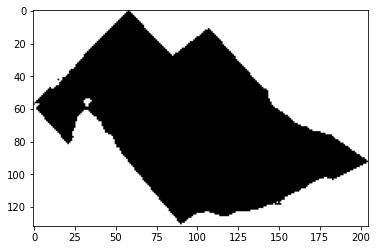

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
print('A área total é {} pixels quadrados'.format(area))

A área total é 12698 pixels quadrados


## Plantas moderadamente saudáveis

In [ ]:
img, area = get_total_area_by_threshold(0.33, 0.75, ndvi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


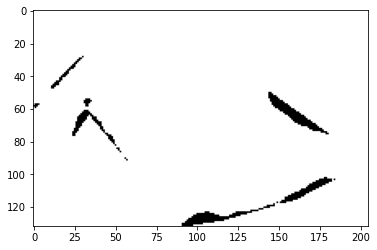

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
print('A área total é {} pixels quadrados'.format(area))

A área total é 719 pixels quadrados


## Plantas saudáveis

In [ ]:
img, area = get_total_area_by_threshold(0.75, 1, ndvi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


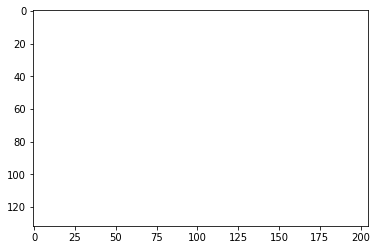

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
print('A área total é {} pixels quadrados'.format(area))

A área total é 0 pixels quadrados


# Processando Dataset 1 criando features baseado na classificação NDVI

In [ ]:
import pandas as pd
from rasterio import RasterioIOError

In [ ]:
def calc_areas(ndvi_path, rgb_path):
  try:
    data = rasterio.open(ndvi_path)
    ndvi = data.read()
    img = cv2.imread(rgb_path, cv2.COLOR_BGR2RGB)
    img1, total_area = get_total_area_by_threshold(-1, 1, ndvi)
    img2, inanimados_area = get_total_area_by_threshold(-1, 0, ndvi)
    img3, plantas_nao_saudaveis_area = get_total_area_by_threshold(0, 0.33, ndvi)
    img4, plantas_moderadamente_saudaveis_area = get_total_area_by_threshold(0.33, 0.75, ndvi)
    img5, plantas_saudaveis_area = get_total_area_by_threshold(0.75, 1, ndvi)
    return ((img1, total_area), 
            (img2, inanimados_area), 
            (img3, plantas_nao_saudaveis_area), 
            (img4, plantas_moderadamente_saudaveis_area), 
            (img5, plantas_saudaveis_area))
  except RasterioIOError:
    return ((pd.NA, pd.NA), 
          (pd.NA, pd.NA), 
          (pd.NA, pd.NA), 
          (pd.NA, pd.NA), 
          (pd.NA, pd.NA))

In [ ]:
def calc_ndvi_summary(ndvi_path):
  try:
    data = rasterio.open(ndvi_path)
    ndvi = data.read()
    ndvi = ndvi[ndvi > -1]
    return (ndvi.mean(), np.median(ndvi), np.min(ndvi), np.max(ndvi))
  except RasterioIOError:
    return (pd.NA, pd.NA, pd.NA, pd.NA)

In [ ]:
df = pd.read_csv('drive/MyDrive/BEMAGRO/dataset_1/DATASET1.csv')
df.head()

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
0      2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   
1      2016         4  2016-04-29   0,00%   algodao  RGB/2016-04-29.tif   
2      2016         7  2016-07-18   0,00%   algodao  RGB/2016-07-18.tif   
3      2016         8  2016-08-07   0,00%  colheita  RGB/2016-08-07.tif   
4      2016         9  2016-09-16   0,89%      soja  RGB/2016-09-16.tif   

                  NDVI  
0  NDVI/2016-03-30.tif  
1  NDVI/2016-04-29.tif  
2  NDVI/2016-07-18.tif  
3  NDVI/2016-08-07.tif  
4  NDVI/2016-09-16.tif

In [ ]:
total_area = []
inanimados_area = []
plantas_nao_saudaveis_area = []
plantas_moderadamente_saudaveis_area = []
plantas_saudaveis_area = []
ndvi_mean = []
ndvi_median = []
ndvi_min = []
ndvi_max = []

for index, row in df.iterrows():
  base_path = 'drive/MyDrive/BEMAGRO/dataset_1/'
  rgb_path = base_path + row['RGB'].replace('RGB', 'JPEG').replace('.tif', '.png')
  ndvi_path = base_path + row['NDVI']
  (_, ta), (_, ia), (_, pnsa), (_, pmsa), (_, psa) = calc_areas(ndvi_path, rgb_path)
  total_area.append(ta)
  inanimados_area.append(ia)
  plantas_nao_saudaveis_area.append(pnsa)
  plantas_moderadamente_saudaveis_area.append(pmsa)
  plantas_saudaveis_area.append(psa)

  mean, median, min, max = calc_ndvi_summary(ndvi_path)
  ndvi_mean.append(mean)
  ndvi_median.append(median)
  ndvi_min.append(min)
  ndvi_max.append(max)

df['total_area'] = total_area
df['inanimados_area'] = inanimados_area
df['plantas_nao_saudaveis_area'] = plantas_nao_saudaveis_area
df['plantas_moderadamente_saudaveis_area'] = plantas_moderadamente_saudaveis_area
df['plantas_saudaveis_area'] = plantas_saudaveis_area
df['ndvi_mean'] = ndvi_mean
df['ndvi_median'] = ndvi_median
df['ndvi_min'] = ndvi_min
df['ndvi_max'] = ndvi_max

In [ ]:
df.head()

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
0      2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   
1      2016         4  2016-04-29   0,00%   algodao  RGB/2016-04-29.tif   
2      2016         7  2016-07-18   0,00%   algodao  RGB/2016-07-18.tif   
3      2016         8  2016-08-07   0,00%  colheita  RGB/2016-08-07.tif   
4      2016         9  2016-09-16   0,89%      soja  RGB/2016-09-16.tif   

                  NDVI total_area inanimados_area plantas_nao_saudaveis_area  \
0  NDVI/2016-03-30.tif      13417               0                         27   
1  NDVI/2016-04-29.tif      13417               0                          3   
2  NDVI/2016-07-18.tif      13417               0                      12698   
3  NDVI/2016-08-07.tif      13417               0                      12931   
4  NDVI/2016-09-16.tif      13417               0                      12859   

  plantas_moderadamente_saudaveis_area plantas_saudaveis_area ndvi_mean  \
0                                13154                    236  0.652147   
1                                 2443                  10971  0.766871   
2                                  719                      0  0.212399   
3                                  486                      0  0.188343   
4                                  558                      0  0.158188   

  ndvi_median  ndvi_min  ndvi_max  
0    0.665605  0.217831   0.81405  
1    0.782663  0.232097  0.842139  
2    0.196501  0.068794  0.742227  
3    0.177599  0.069947  0.701362  
4    0.142414  0.096948  0.545478

## Detectando ciclo de cultura


In [ ]:
plantacoes = []
index_to_cut = 0
for index, row in df.iterrows():
  if(row['Cultura'] == 'colheita'):
    plantacoes.append(df.iloc[index_to_cut:index+1])
    index_to_cut = index+1

print(len(plantacoes))
plantacoes[0].head()



11


temp ano  temp mes        Data Nublado   Cultura                 RGB  \
0      2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   
1      2016         4  2016-04-29   0,00%   algodao  RGB/2016-04-29.tif   
2      2016         7  2016-07-18   0,00%   algodao  RGB/2016-07-18.tif   
3      2016         8  2016-08-07   0,00%  colheita  RGB/2016-08-07.tif   

                  NDVI total_area inanimados_area plantas_nao_saudaveis_area  \
0  NDVI/2016-03-30.tif      13417               0                         27   
1  NDVI/2016-04-29.tif      13417               0                          3   
2  NDVI/2016-07-18.tif      13417               0                      12698   
3  NDVI/2016-08-07.tif      13417               0                      12931   

  plantas_moderadamente_saudaveis_area plantas_saudaveis_area ndvi_mean  \
0                                13154                    236  0.652147   
1                                 2443                  10971  0.766871   
2                                  719                      0  0.212399   
3                                  486                      0  0.188343   

  ndvi_median  ndvi_min  ndvi_max  
0    0.665605  0.217831   0.81405  
1    0.782663  0.232097  0.842139  
2    0.196501  0.068794  0.742227  
3    0.177599  0.069947  0.701362

## Testes de hipótese

In [ ]:
plantacoes[0].head()

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
0      2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   
1      2016         4  2016-04-29   0,00%   algodao  RGB/2016-04-29.tif   
2      2016         7  2016-07-18   0,00%   algodao  RGB/2016-07-18.tif   
3      2016         8  2016-08-07   0,00%  colheita  RGB/2016-08-07.tif   

                  NDVI total_area inanimados_area plantas_nao_saudaveis_area  \
0  NDVI/2016-03-30.tif      13417               0                         27   
1  NDVI/2016-04-29.tif      13417               0                          3   
2  NDVI/2016-07-18.tif      13417               0                      12698   
3  NDVI/2016-08-07.tif      13417               0                      12931   

  plantas_moderadamente_saudaveis_area plantas_saudaveis_area ndvi_mean  \
0                                13154                    236  0.652147   
1                                 2443                  10971  0.766871   
2                                  719                      0  0.212399   
3                                  486                      0  0.188343   

  ndvi_median  ndvi_min  ndvi_max  
0    0.665605  0.217831   0.81405  
1    0.782663  0.232097  0.842139  
2    0.196501  0.068794  0.742227  
3    0.177599  0.069947  0.701362

## Imagens RGB

algodao 2016-03-30
algodao 2016-04-29
algodao 2016-07-18
colheita 2016-08-07


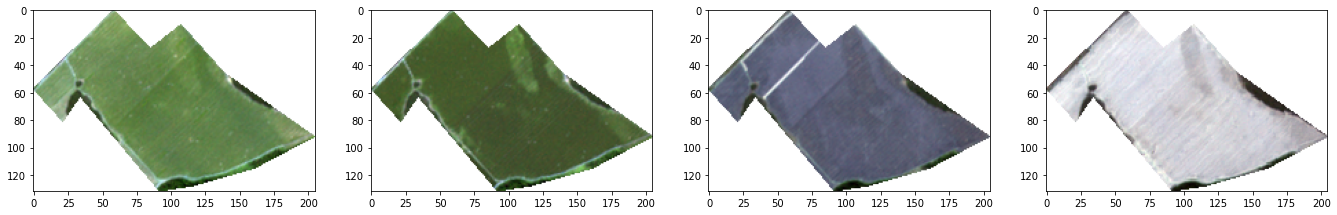

In [ ]:
plt.figure(figsize=(120, 50))
for index, row in plantacoes[0].iterrows():
  base_path = 'drive/MyDrive/BEMAGRO/dataset_1/'
  rgb_path = base_path + row['RGB'].replace('RGB', 'JPEG').replace('.tif', '.png')
  img_rgb = cv2.imread(rgb_path, cv2.COLOR_BGR2RGB)
  print(row['Cultura'], row['Data'])
  plt.subplot(3, 20, index + 1)
  plt.imshow(img_rgb)
plt.show()



## Imagens com subdesenvolvimento

algodao 2016-03-30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


algodao 2016-04-29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


algodao 2016-07-18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


colheita 2016-08-07


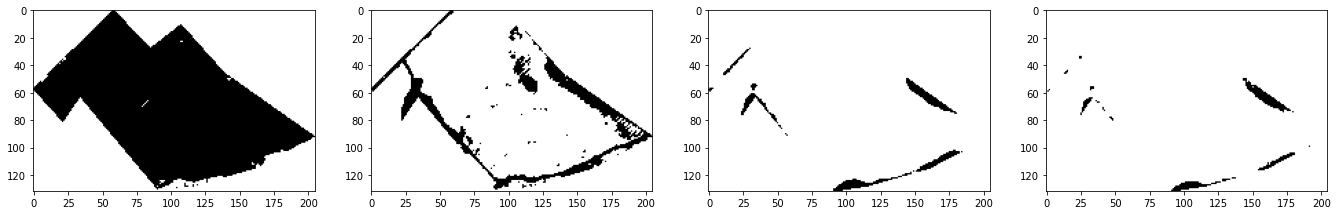

In [ ]:
plt.figure(figsize=(120, 50))
for index, row in plantacoes[0].iterrows():
  base_path = 'drive/MyDrive/BEMAGRO/dataset_1/'
  rgb_path = base_path + row['RGB'].replace('RGB', 'JPEG').replace('.tif', '.png')
  ndvi_path = base_path + row['NDVI']
  (img_area_total, _), (img_inanimados, _), (img_nao_saudavel, _), (img_moderadamente_saudavel, _), (img_saudaveis, _) = calc_areas(ndvi_path, rgb_path)
  print(row['Cultura'], row['Data'])
  plt.subplot(3, 20, index + 1)
  plt.imshow(img_moderadamente_saudavel, cmap="gray")
  
plt.show()



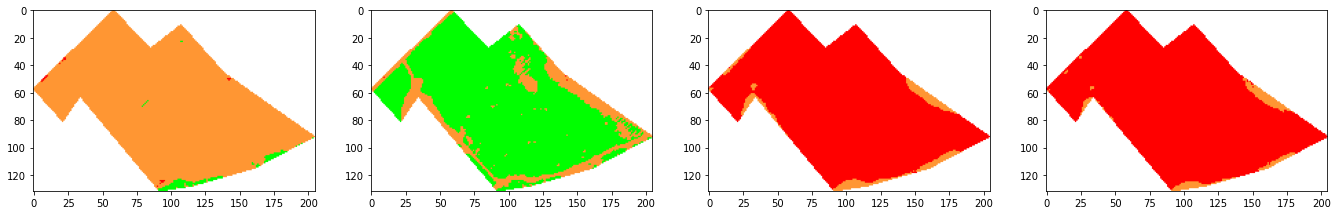

In [ ]:
plt.figure(figsize=(120, 50))
for index, row in plantacoes[0].iterrows():
  base_path = 'drive/MyDrive/BEMAGRO/dataset_1/'
  rgb_path = base_path + row['RGB'].replace('RGB', 'JPEG').replace('.tif', '.png')
  ndvi_path = base_path + row['NDVI']
  
  img = generate_ndvi_colored(ndvi_path, rgb_path)

  plt.subplot(3, 20, index + 1)
  plt.imshow(img)
  
plt.show()



## Gerando dinamicamente

In [ ]:
culturas = df['Cultura'].unique()

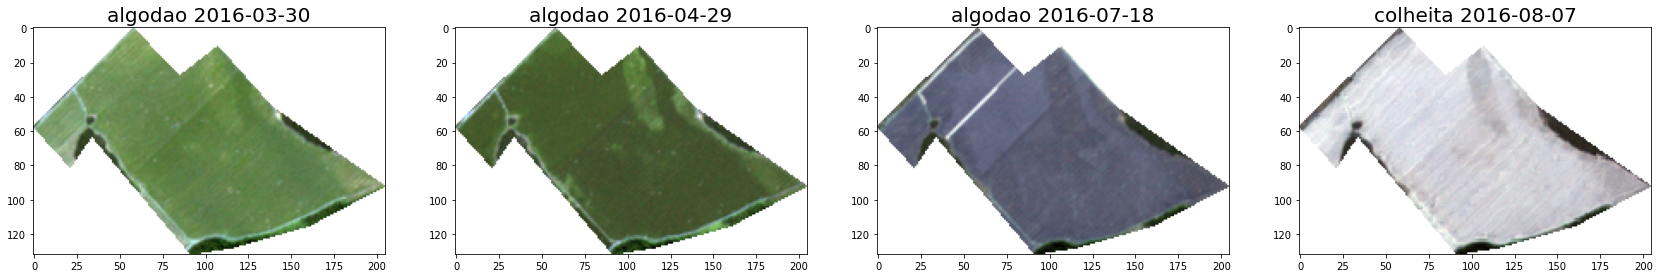

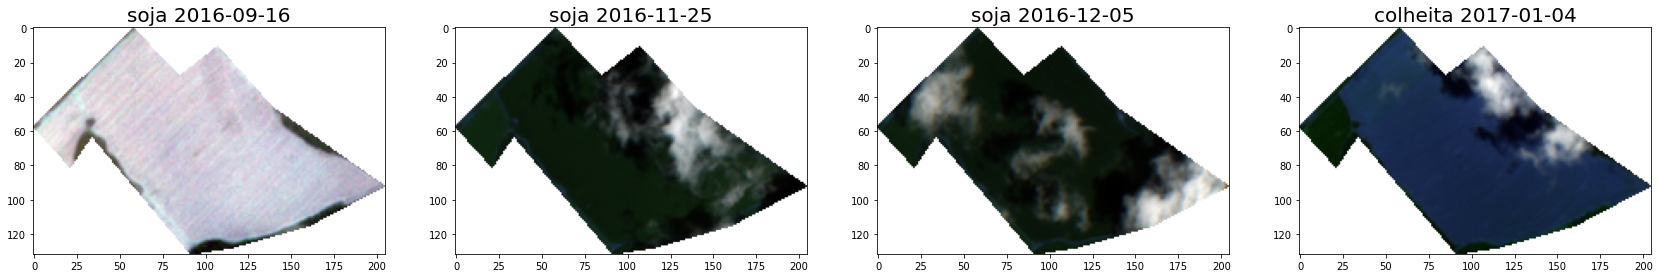

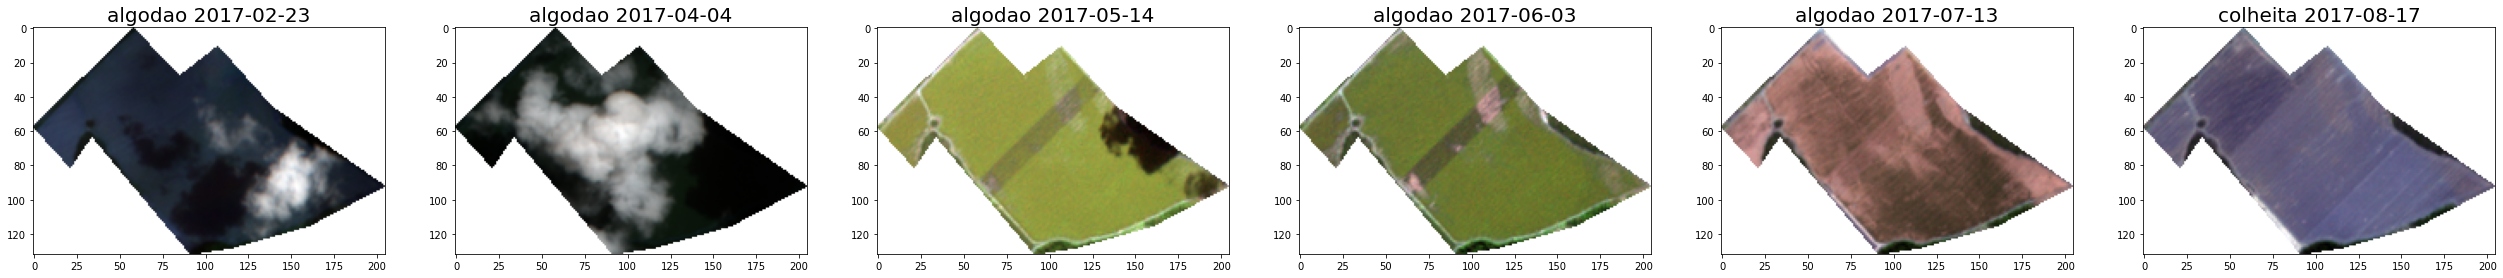

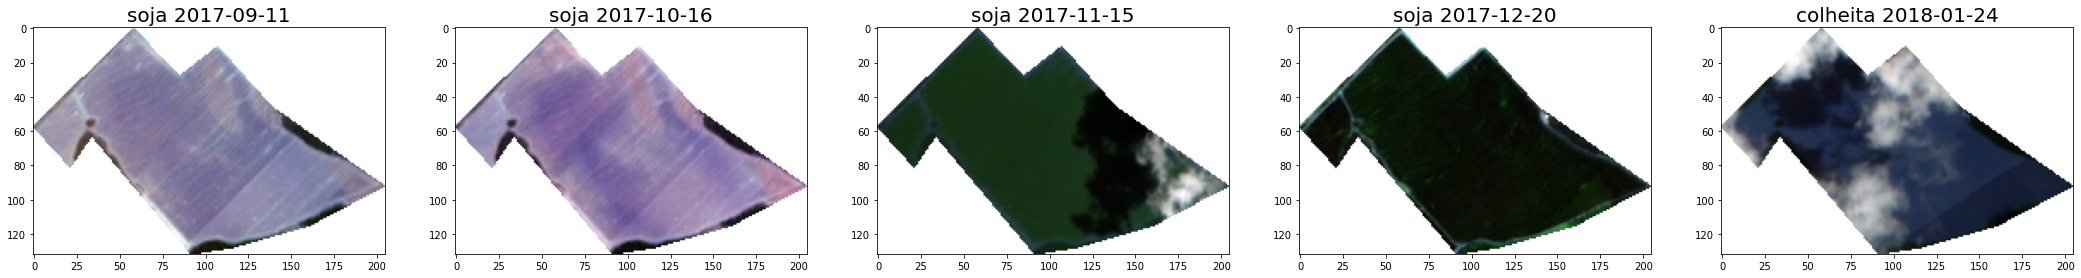

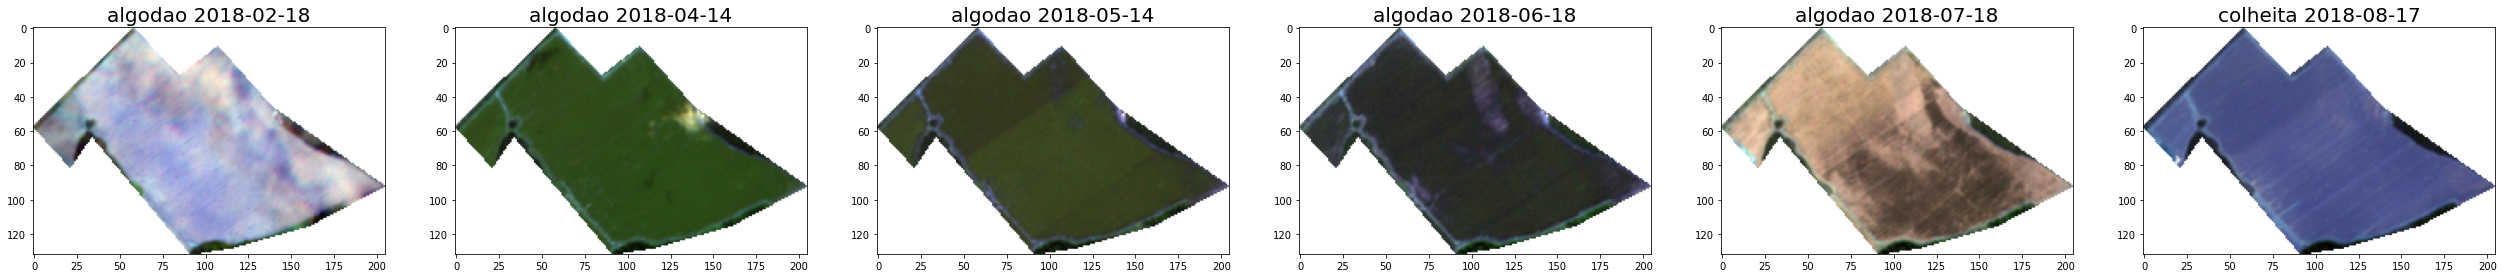

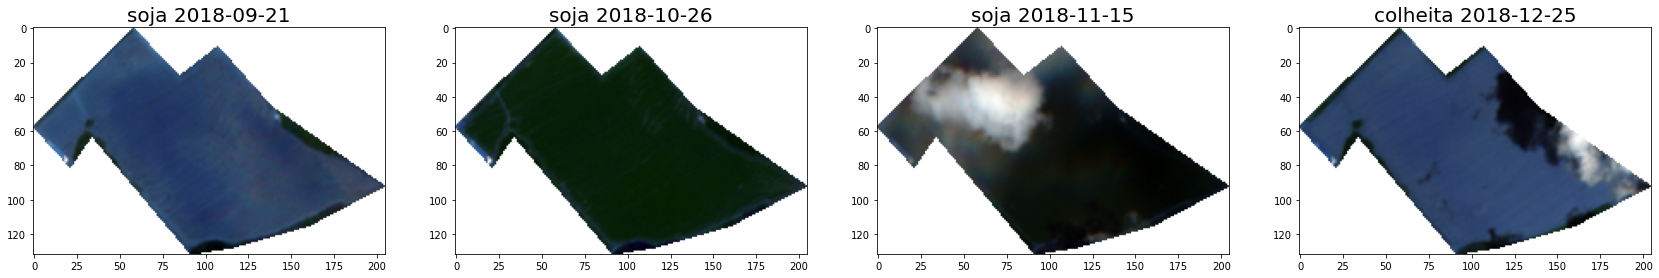

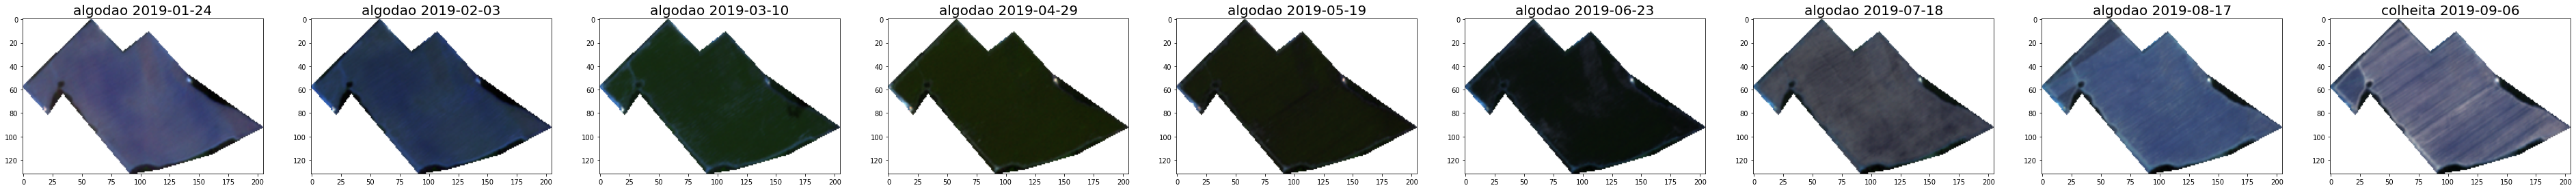

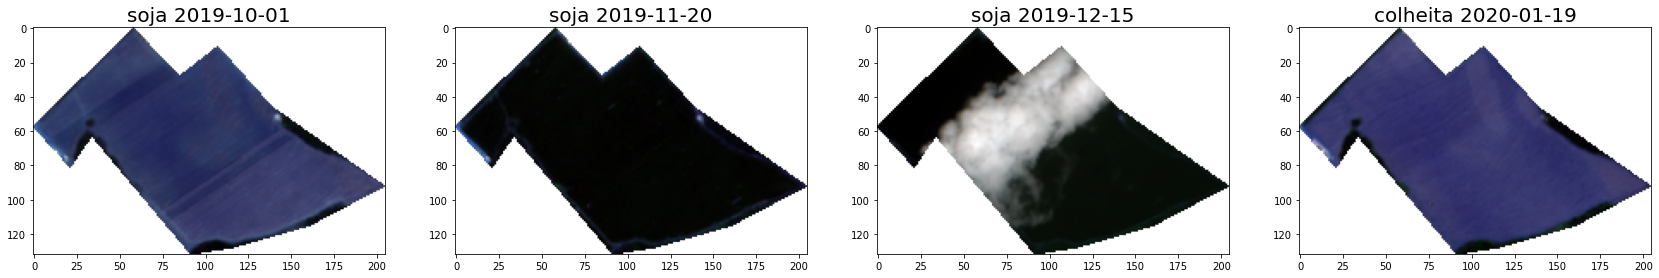

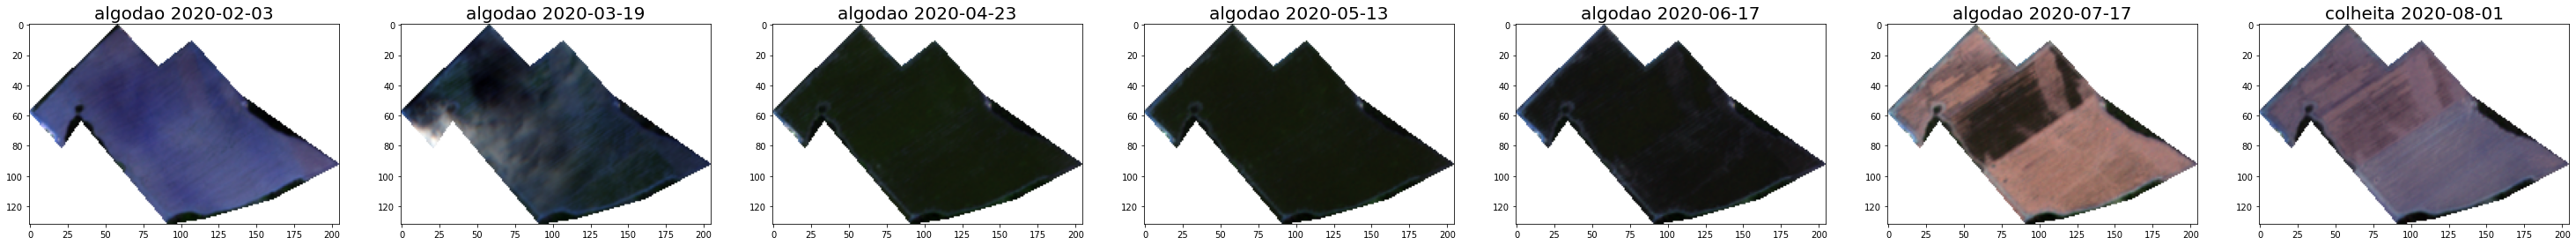

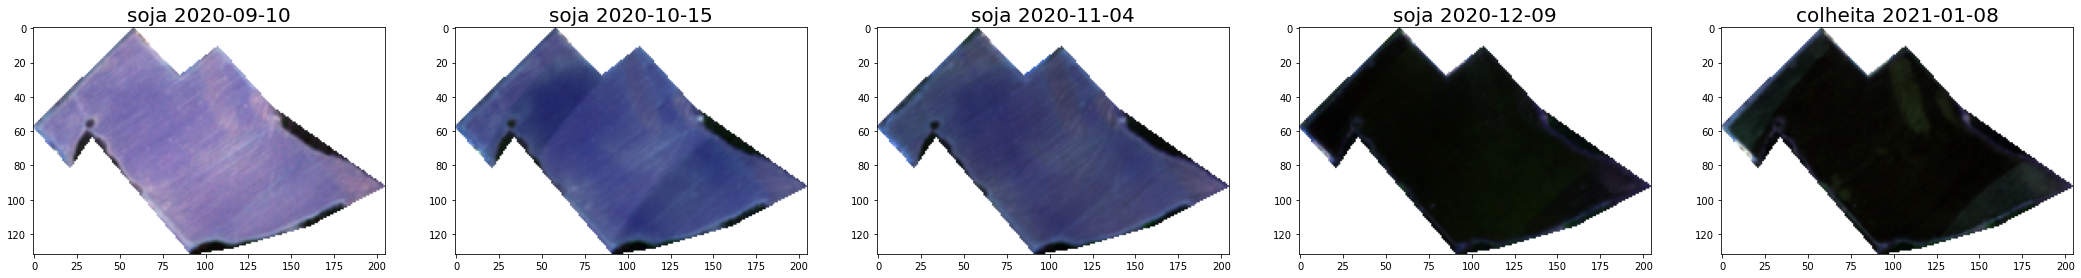

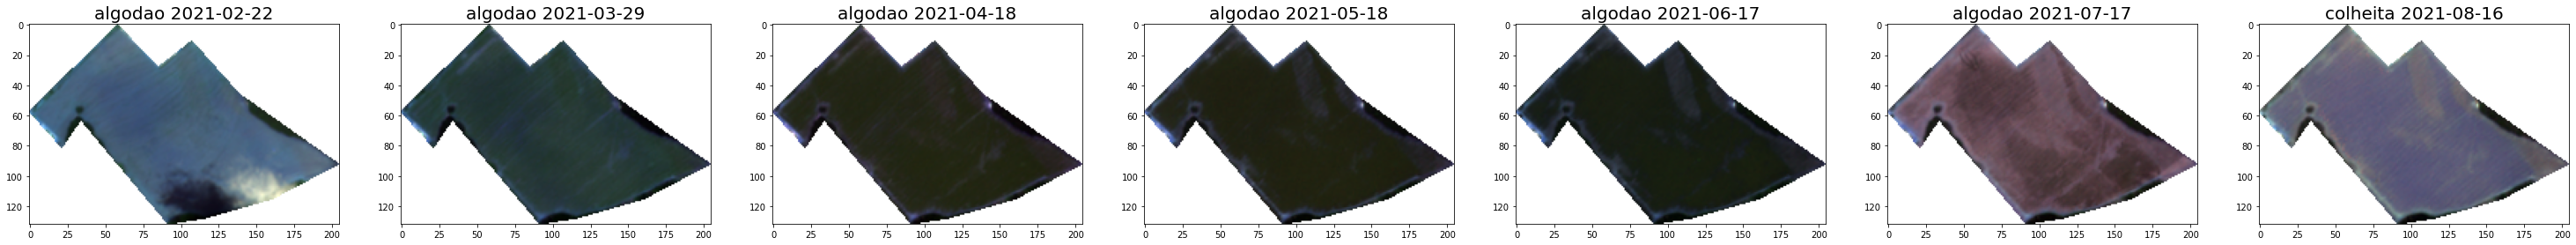

In [ ]:
for cultura in plantacoes:
  i = 0
  plt.figure(figsize=(150, 80))
  for index, row in cultura.iterrows():
    base_path = 'drive/MyDrive/BEMAGRO/dataset_1/'
    rgb_path = base_path + row['RGB'].replace('RGB', 'JPEG').replace('.tif', '.png')
    img_rgb = cv2.imread(rgb_path, cv2.COLOR_BGR2RGB)
    if(img_rgb is not None):
      i += 1
      plt.subplot(3, 20, i)
      plt.title(label = "{} {}".format(row['Cultura'], row['Data']), fontsize=20)
      plt.imshow(img_rgb)
  plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


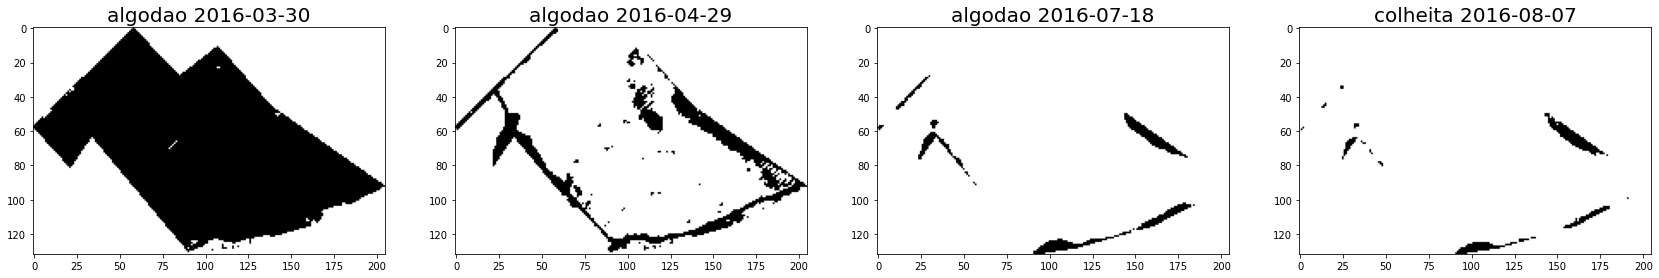

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


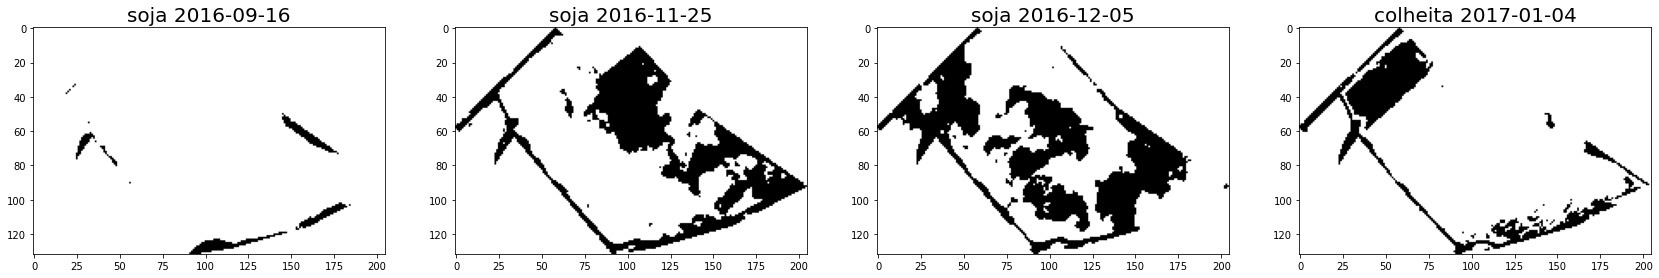

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


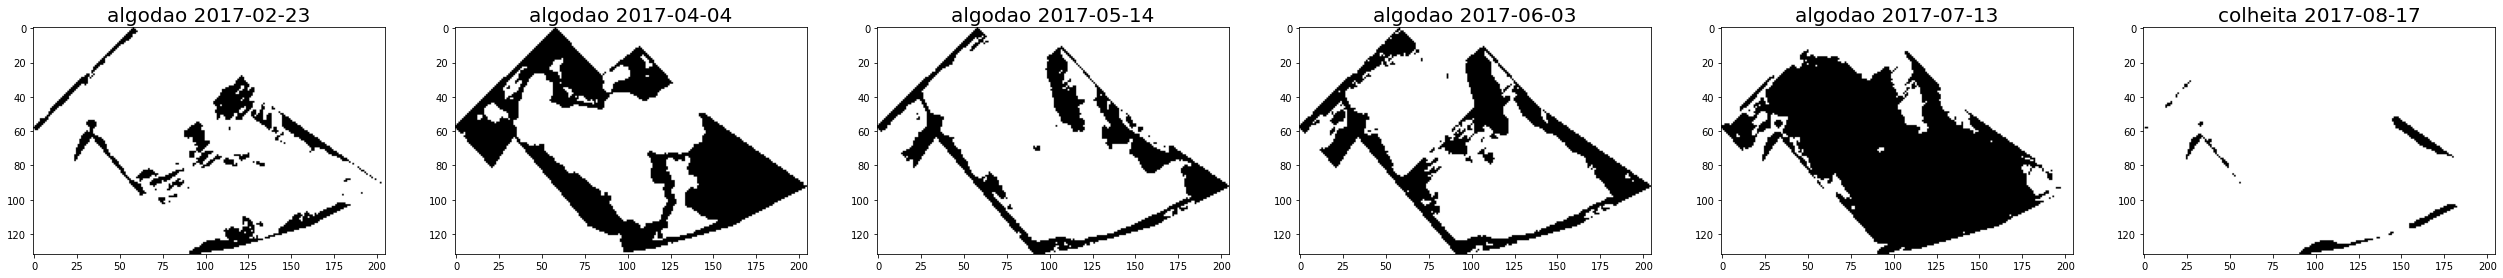

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


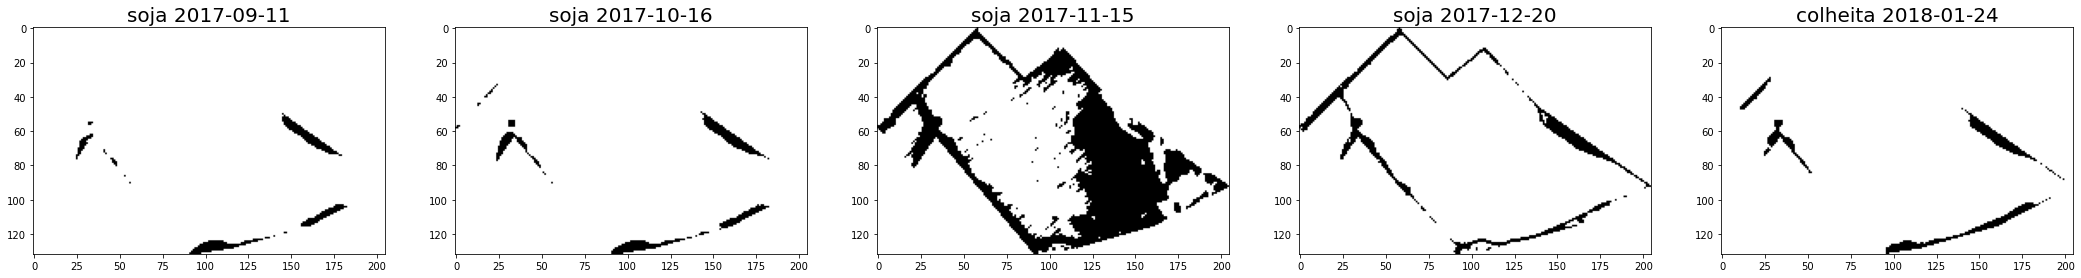

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


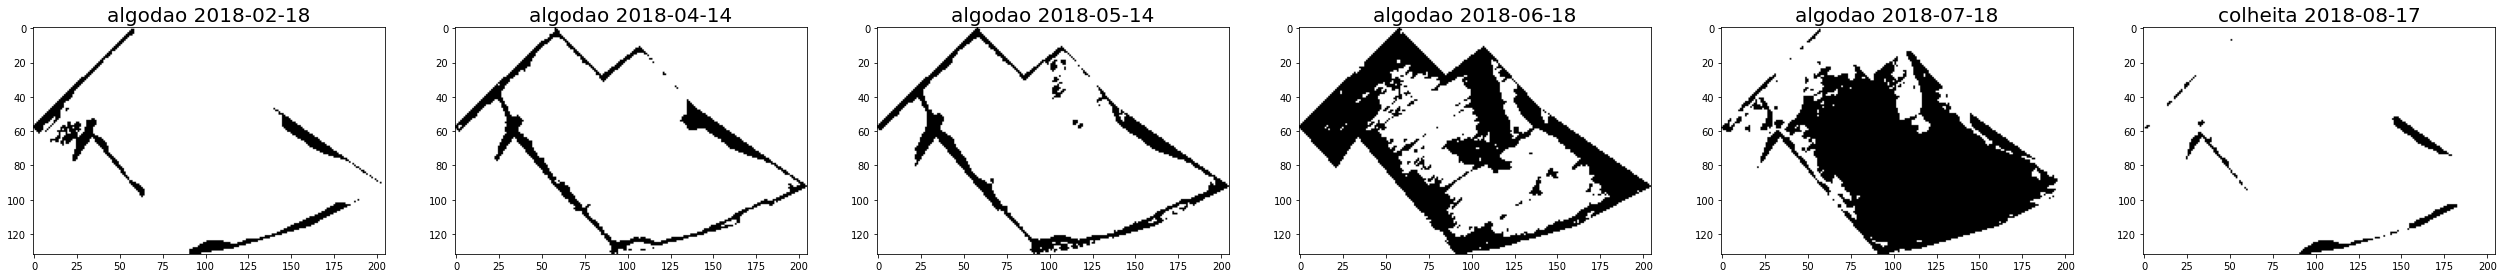

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


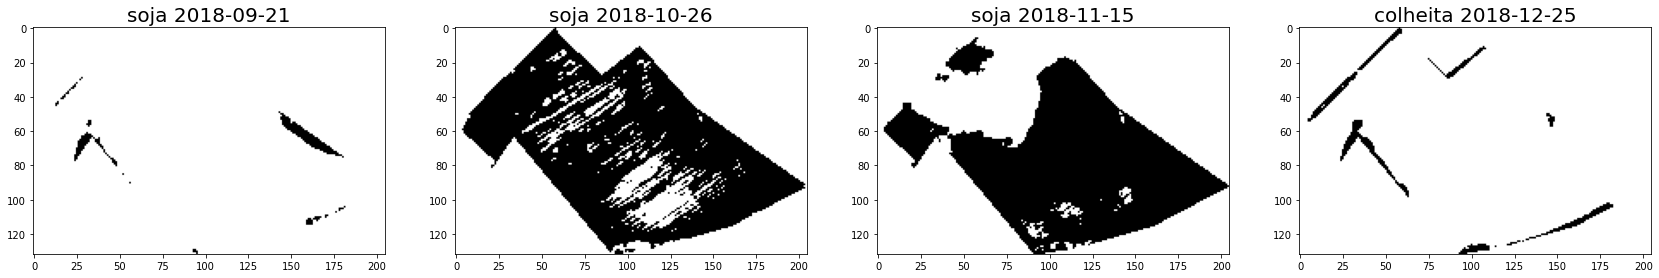

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


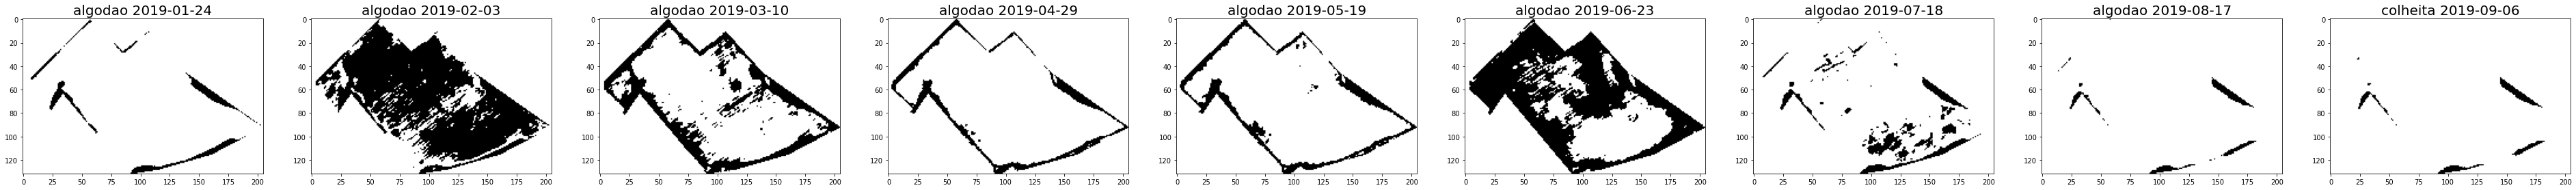

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


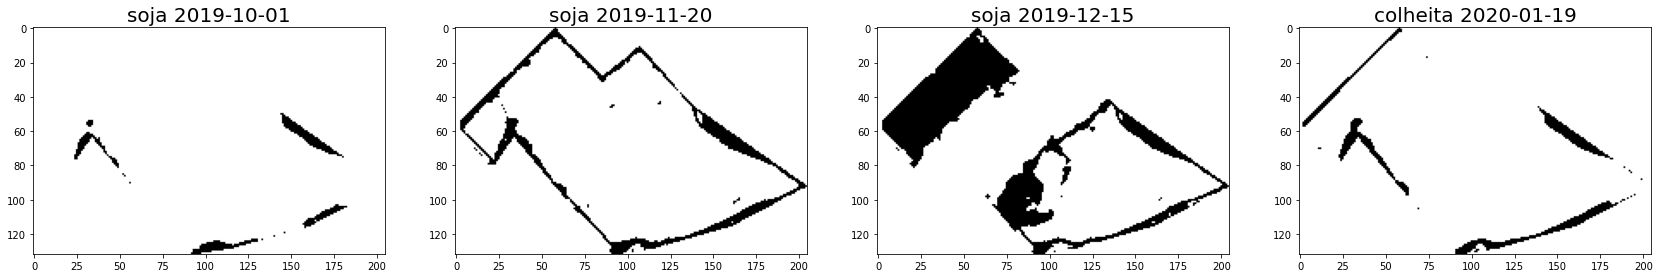

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


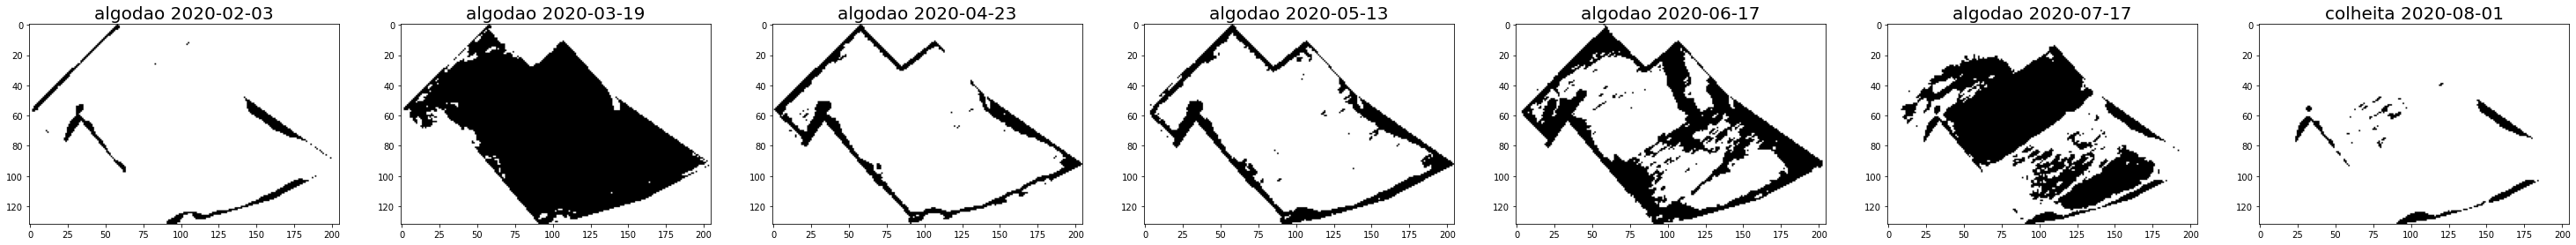

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


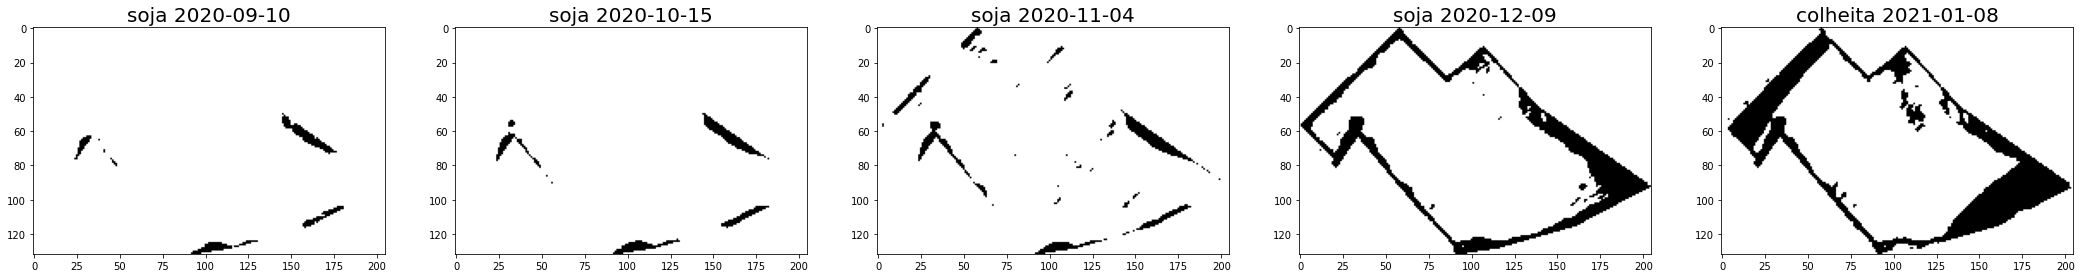

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


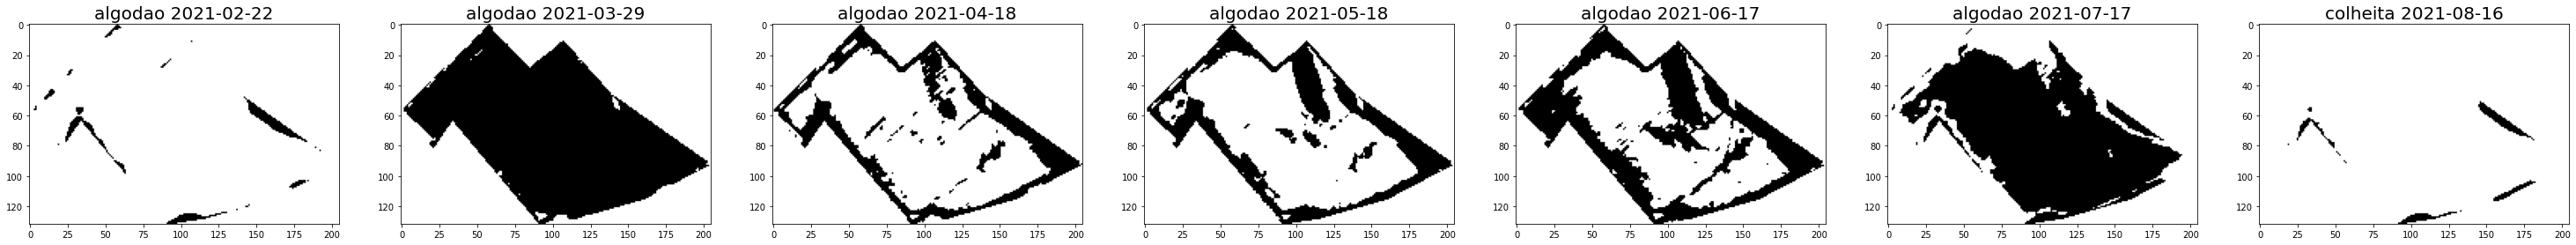

In [ ]:
for cultura in plantacoes:
  i = 0
  plt.figure(figsize=(150, 80))
  for index, row in cultura.iterrows():
    base_path = 'drive/MyDrive/BEMAGRO/dataset_1/'
    rgb_path = base_path + row['RGB'].replace('RGB', 'JPEG').replace('.tif', '.png')
    ndvi_path = base_path + row['NDVI']
    (img_area_total, _), (_, _), (img_nao_saudavel, _), (img_moderadamente_saudavel, _), (_, _) = calc_areas(ndvi_path, rgb_path)
    if(img_moderadamente_saudavel is not pd.NA):
      i += 1
      plt.subplot(3, 20, i)
      plt.title(label = "{} {}".format(row['Cultura'], row['Data']), fontsize=20)
      plt.imshow(img_moderadamente_saudavel, cmap="gray")
  plt.show()
    

algodao 2016-03-30


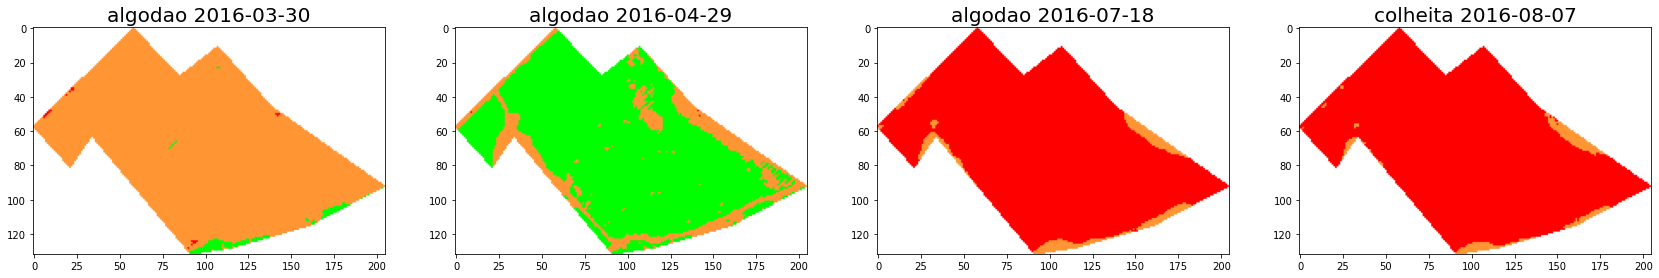

soja 2016-09-16


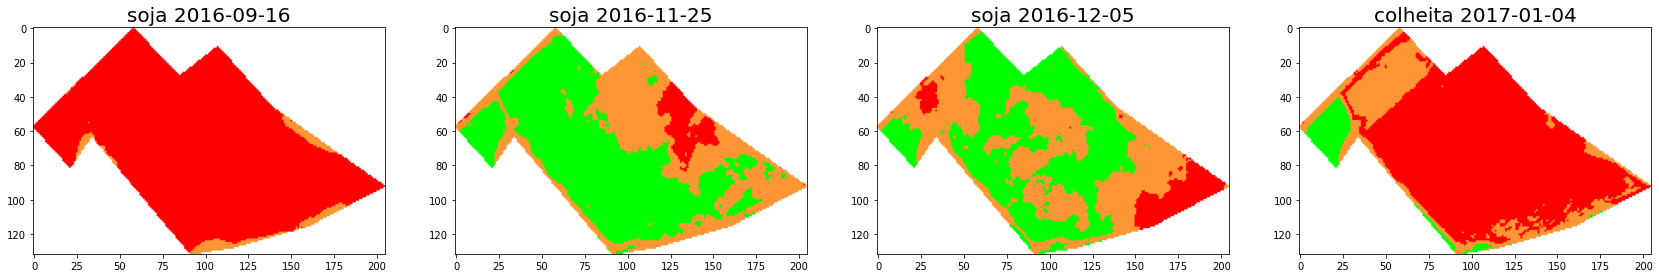

algodao 2017-02-23


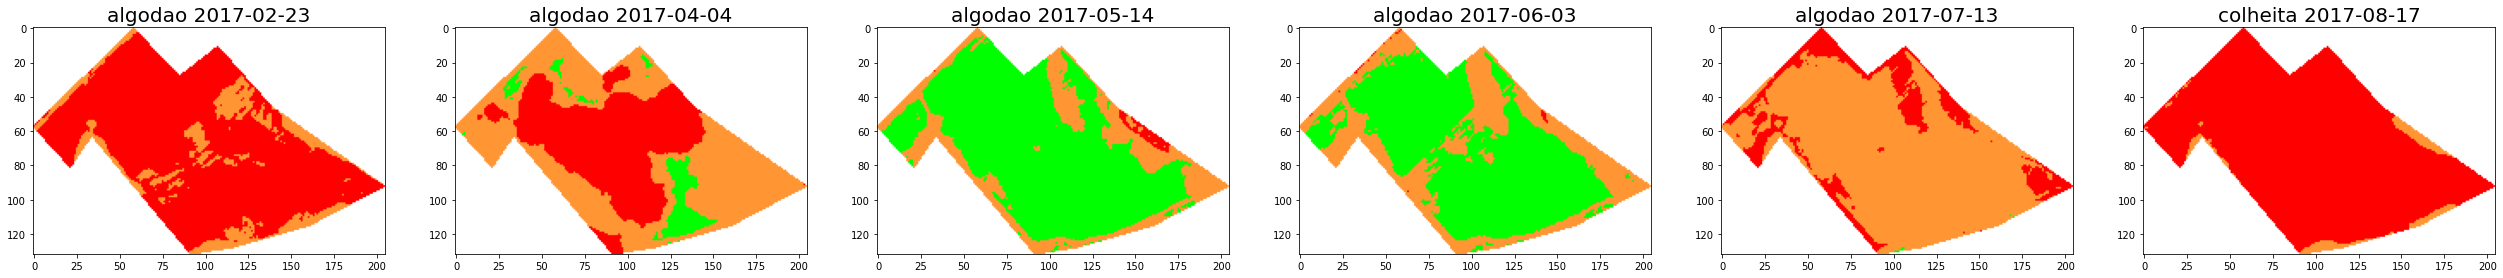

soja 2017-09-11


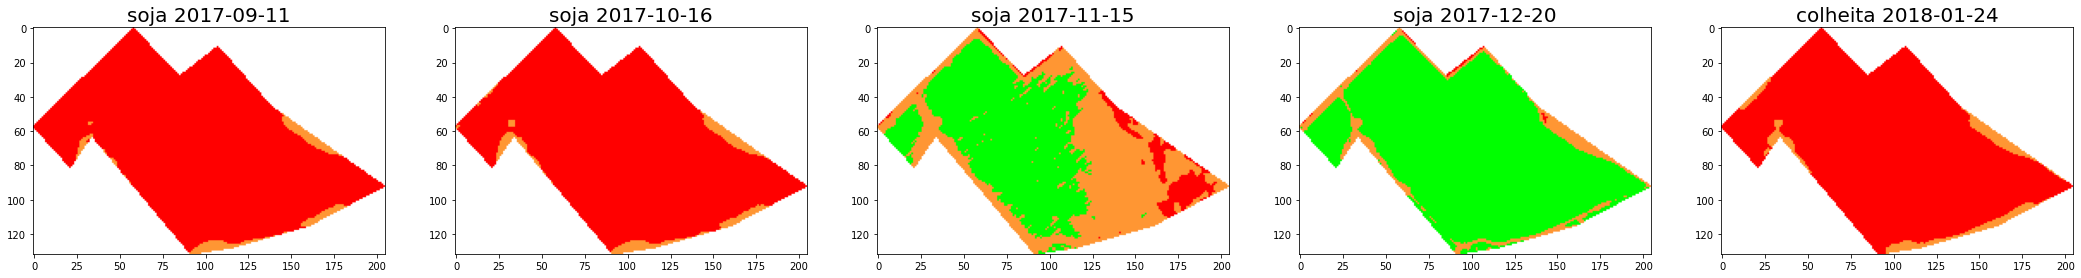

algodao 2018-02-18
não foi encontrada a img: drive/MyDrive/BEMAGRO/dataset_1/NDVI/2018-03-20.tif


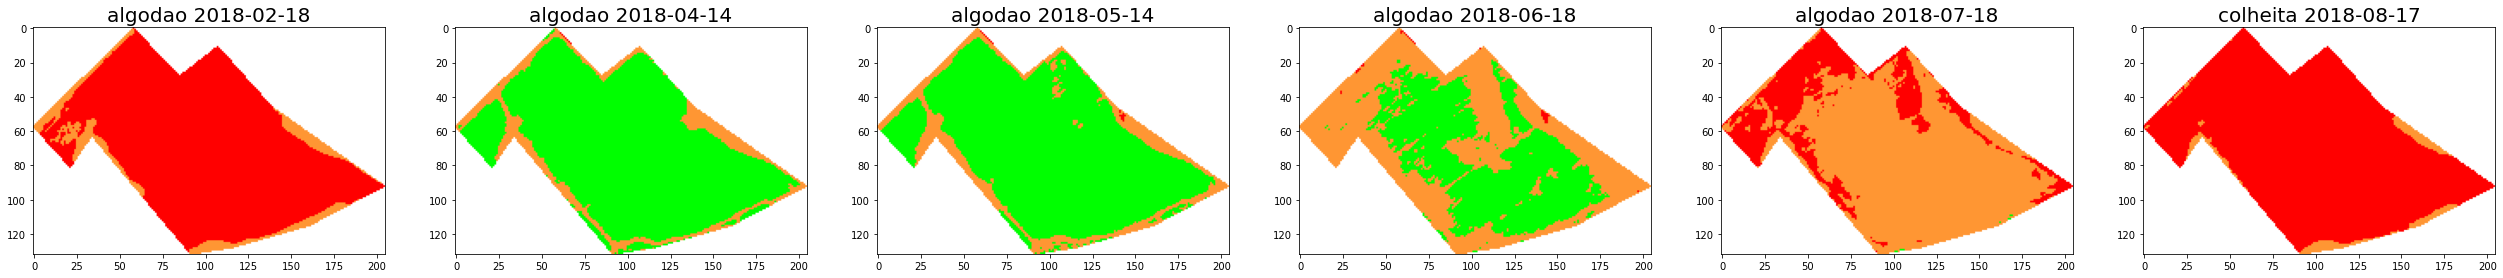

soja 2018-09-21


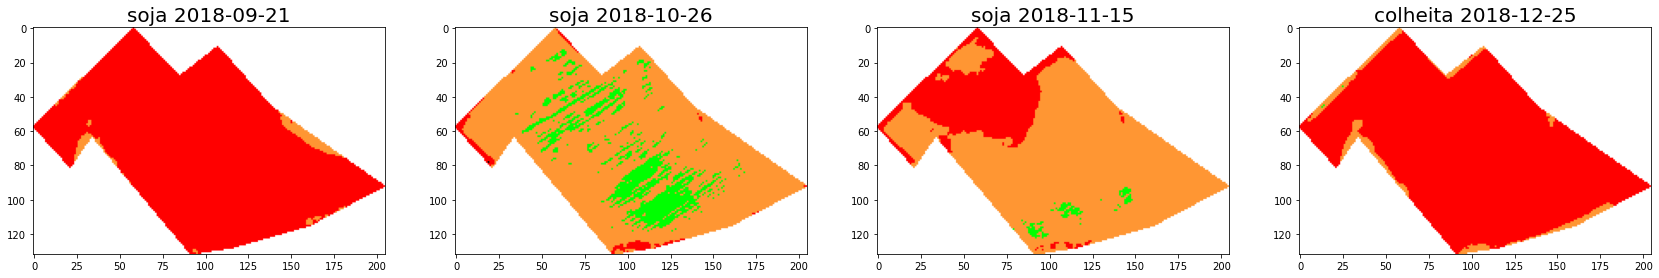

algodao 2019-01-24


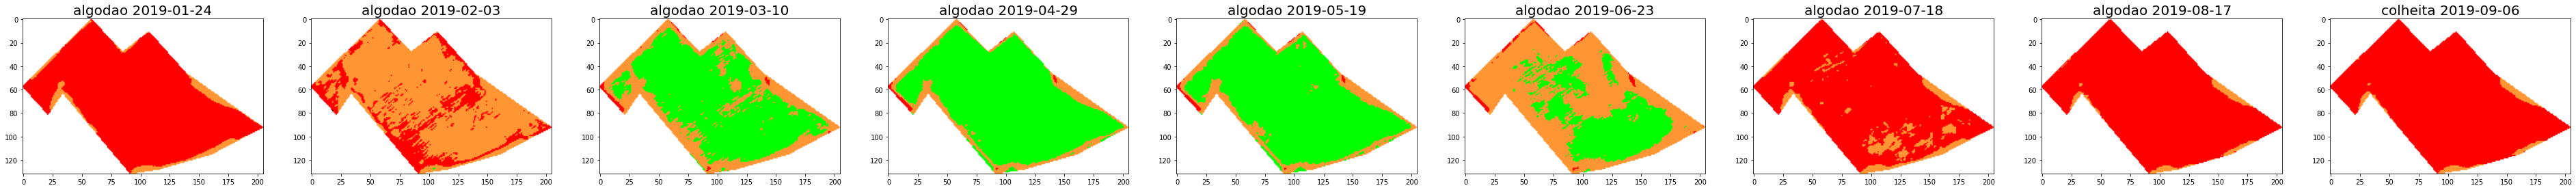

soja 2019-10-01


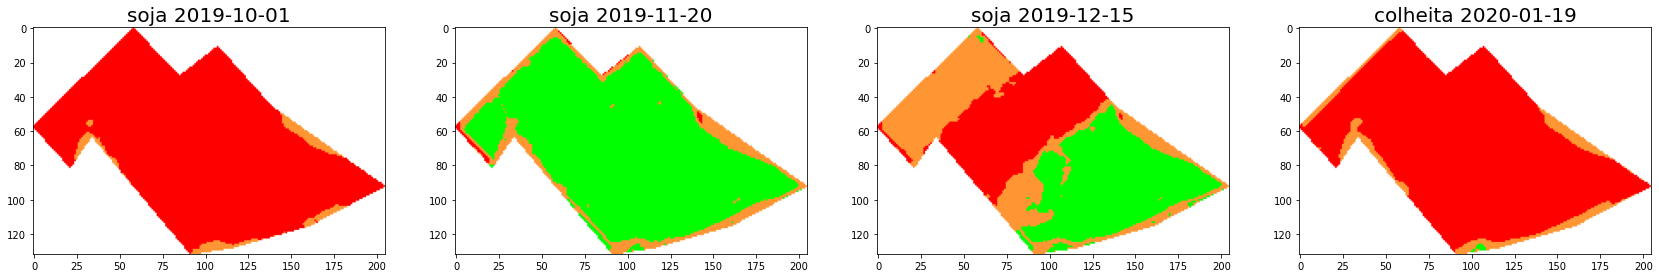

algodao 2020-02-03


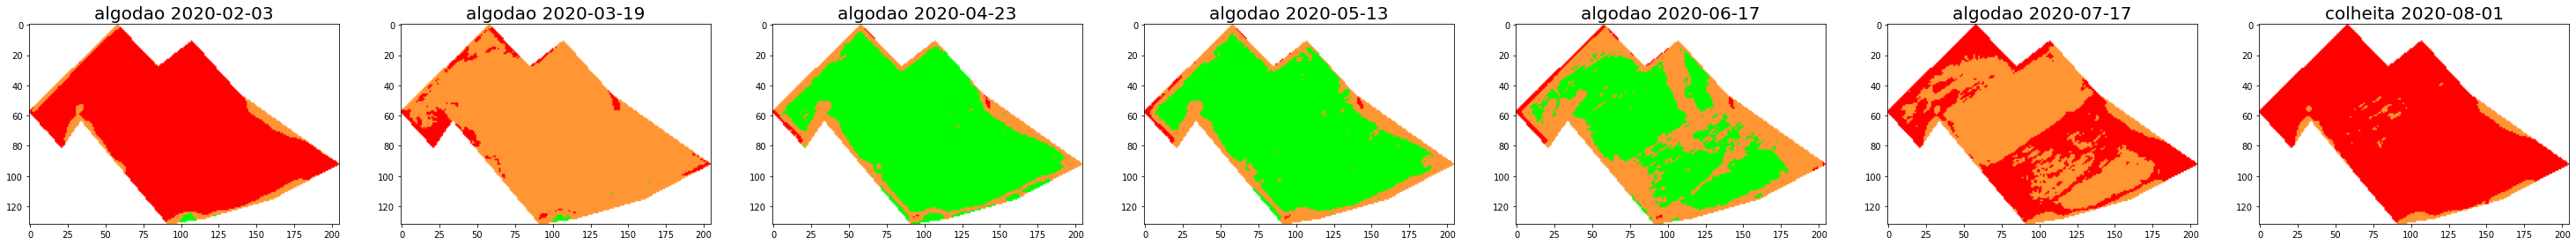

soja 2020-09-10


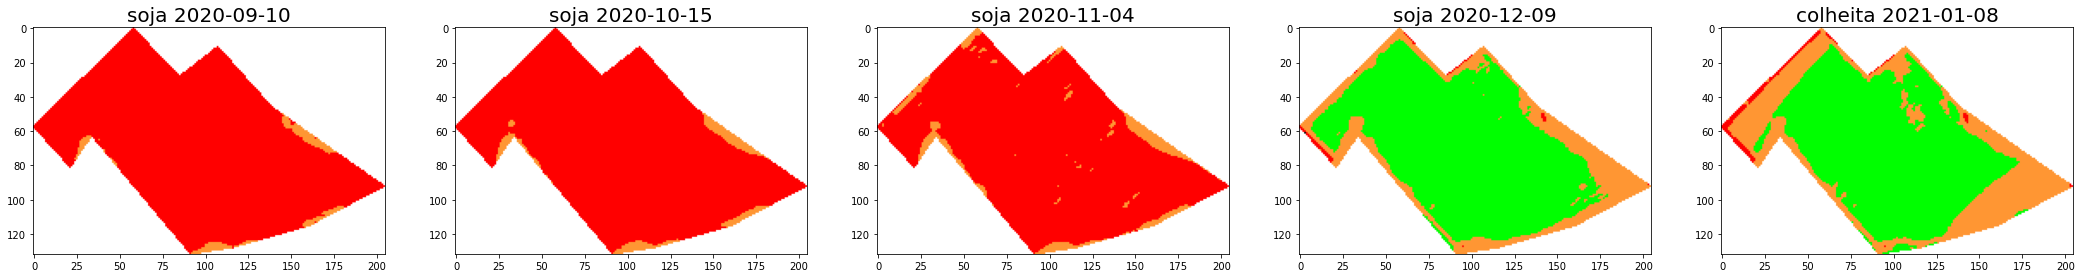

algodao 2021-02-22


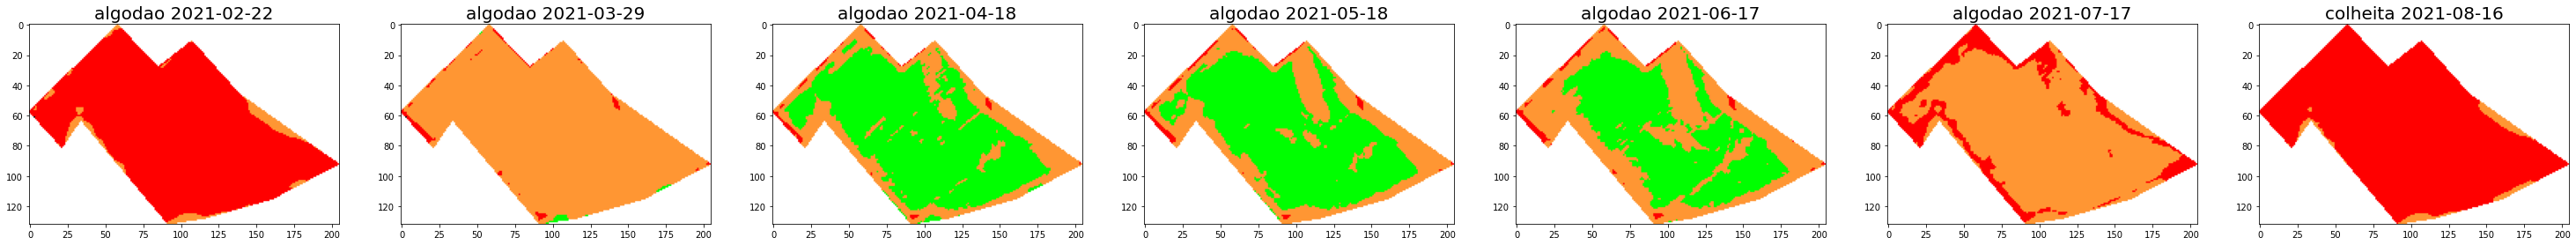

In [ ]:
for cultura in plantacoes:
  i = 0
  plt.figure(figsize=(150, 80))
  for index, row in cultura.iterrows():
    try:
      base_path = 'drive/MyDrive/BEMAGRO/dataset_1/'
      rgb_path = base_path + row['RGB'].replace('RGB', 'JPEG').replace('.tif', '.png')
      ndvi_path = base_path + row['NDVI']
      img = generate_ndvi_colored(ndvi_path, rgb_path)
      i += 1
      plt.subplot(3, 20, i)
      plt.title(label = "{} {}".format(row['Cultura'], row['Data']), fontsize=20)
      plt.imshow(img, cmap="gray")
    except:
      print('não foi encontrada a img: {}'.format(ndvi_path))
  plt.show()

## Verificando ndvi por plantios

In [ ]:
plantacoes[0]

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
0      2016         3  2016-03-30   0,00%   algodao  RGB/2016-03-30.tif   
1      2016         4  2016-04-29   0,00%   algodao  RGB/2016-04-29.tif   
2      2016         7  2016-07-18   0,00%   algodao  RGB/2016-07-18.tif   
3      2016         8  2016-08-07   0,00%  colheita  RGB/2016-08-07.tif   

                  NDVI total_area inanimados_area plantas_nao_saudaveis_area  \
0  NDVI/2016-03-30.tif      13417               0                         27   
1  NDVI/2016-04-29.tif      13417               0                          3   
2  NDVI/2016-07-18.tif      13417               0                      12698   
3  NDVI/2016-08-07.tif      13417               0                      12931   

  plantas_moderadamente_saudaveis_area plantas_saudaveis_area ndvi_mean  \
0                                13154                    236  0.652147   
1                                 2443                  10971  0.766871   
2                                  719                      0  0.212399   
3                                  486                      0  0.188343   

  ndvi_median  ndvi_min  ndvi_max  
0    0.665605  0.217831   0.81405  
1    0.782663  0.232097  0.842139  
2    0.196501  0.068794  0.742227  
3    0.177599  0.069947  0.701362

In [ ]:
plantacoes[2]

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
8       2017         2  2017-02-23  13,08%   algodao  RGB/2017-02-23.tif   
9       2017         4  2017-04-04  56,00%   algodao  RGB/2017-04-04.tif   
10      2017         5  2017-05-14   0,00%   algodao  RGB/2017-05-14.tif   
11      2017         6  2017-06-03   0,00%   algodao  RGB/2017-06-03.tif   
12      2017         7  2017-07-13   0,00%   algodao  RGB/2017-07-13.tif   
13      2017         8  2017-08-17   0,00%  colheita  RGB/2017-08-17.tif   

                   NDVI total_area inanimados_area plantas_nao_saudaveis_area  \
8   NDVI/2017-02-23.tif      13417               0                      11270   
9   NDVI/2017-04-04.tif      13417               0                       5417   
10  NDVI/2017-05-14.tif      13417               0                        178   
11  NDVI/2017-06-03.tif      13417               0                         37   
12  NDVI/2017-07-13.tif      13417               0                       2323   
13  NDVI/2017-08-17.tif      13417               0                      12863   

   plantas_moderadamente_saudaveis_area plantas_saudaveis_area ndvi_mean  \
8                                  2147                      0    0.2853   
9                                  7155                    845  0.411087   
10                                 3373                   9866  0.761043   
11                                 4564                   8816  0.739732   
12                                11085                      9  0.473736   
13                                  554                      0  0.242873   

   ndvi_median  ndvi_min  ndvi_max  
8     0.281431  0.101028  0.640738  
9     0.442037  0.016755  0.814571  
10    0.806016  0.143106  0.836742  
11    0.783665  0.150552  0.826237  
12    0.483491  0.082103  0.775922  
13    0.238325  0.061667  0.697475

In [ ]:
plantacoes[4]

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
19      2018         2  2018-02-18   0,00%   algodao  RGB/2018-02-18.tif   
20      2018         3  2018-03-20   0,00%   algodao  RGB/2018-03-20.tif   
21      2018         4  2018-04-14   0,00%   algodao  RGB/2018-04-14.tif   
22      2018         5  2018-05-14   0,00%   algodao  RGB/2018-05-14.tif   
23      2018         6  2018-06-18   0,00%   algodao  RGB/2018-06-18.tif   
24      2018         7  2018-07-18   0,00%   algodao  RGB/2018-07-18.tif   
25      2018         8  2018-08-17   0,03%  colheita  RGB/2018-08-17.tif   

                   NDVI total_area inanimados_area plantas_nao_saudaveis_area  \
19  NDVI/2018-02-18.tif      13417               0                      12144   
20  NDVI/2018-03-20.tif       <NA>            <NA>                       <NA>   
21  NDVI/2018-04-14.tif      13417               0                          7   
22  NDVI/2018-05-14.tif      13417               0                         20   
23  NDVI/2018-06-18.tif      13417               0                         44   
24  NDVI/2018-07-18.tif      13417               0                       3316   
25  NDVI/2018-08-17.tif      13417               0                      12823   

   plantas_moderadamente_saudaveis_area plantas_saudaveis_area ndvi_mean  \
19                                 1273                      0  0.265431   
20                                 <NA>                   <NA>      <NA>   
21                                 1847                  11563  0.816921   
22                                 2157                  11240  0.800444   
23                                 7112                   6261  0.709316   
24                                10091                     10  0.434464   
25                                  594                      0  0.236554   

   ndvi_median  ndvi_min  ndvi_max  
19     0.24114  0.110764  0.748342  
20        <NA>      <NA>      <NA>  
21    0.844597  0.203494  0.866138  
22    0.832867  0.154798  0.851411  
23    0.746339  0.125772  0.789866  
24    0.408678  0.079721  0.770063  
25    0.230701  0.026208  0.713037

In [ ]:
plantacoes[6]

temp ano  temp mes        Data Nublado   Cultura                 RGB  \
30      2019         1  2019-01-24   0,11%   algodao  RGB/2019-01-24.tif   
31      2019         2  2019-02-03   0,08%   algodao  RGB/2019-02-03.tif   
32      2019         3  2019-03-10   0,08%   algodao  RGB/2019-03-10.tif   
33      2019         4  2019-04-29   0,02%   algodao  RGB/2019-04-29.tif   
34      2019         5  2019-05-19   0,00%   algodao  RGB/2019-05-19.tif   
35      2019         6  2019-06-23   0,05%   algodao  RGB/2019-06-23.tif   
36      2019         7  2019-07-18   0,05%   algodao  RGB/2019-07-18.tif   
37      2019         8  2019-08-17   0,05%   algodao  RGB/2019-08-17.tif   
38      2019         9  2019-09-06   3,00%  colheita  RGB/2019-09-06.tif   

                   NDVI total_area inanimados_area plantas_nao_saudaveis_area  \
30  NDVI/2019-01-24.tif      13417               0                      12444   
31  NDVI/2019-02-03.tif      13417               1                       3033   
32  NDVI/2019-03-10.tif      13417               0                        135   
33  NDVI/2019-04-29.tif      13417               0                        103   
34  NDVI/2019-05-19.tif      13417               0                        110   
35  NDVI/2019-06-23.tif      13417               0                        226   
36  NDVI/2019-07-18.tif      13417               1                      11735   
37  NDVI/2019-08-17.tif      13417               0                      12907   
38  NDVI/2019-09-06.tif      13417               0                      12918   

   plantas_moderadamente_saudaveis_area plantas_saudaveis_area ndvi_mean  \
30                                  973                      0  0.237416   
31                                10380                      3  0.361558   
32                                 4095                   9187  0.740359   
33                                 1788                  11526  0.801305   
34                                 2128                  11179  0.784125   
35                                 8538                   4653  0.689621   
36                                 1681                      0  0.297156   
37                                  510                      0  0.226295   
38                                  499                      0  0.211798   

   ndvi_median  ndvi_min  ndvi_max  
30    0.217679  0.074259   0.63475  
31    0.357234  -0.00576  0.765034  
32    0.779583  0.032474   0.82312  
33     0.83433  0.023218  0.846311  
34    0.815668  0.030585  0.845895  
35    0.728545  0.030234  0.814404  
36    0.290354       0.0   0.74778  
37    0.222333  0.004408  0.653714  
38    0.206323  0.018575  0.649839

## Testes

3143


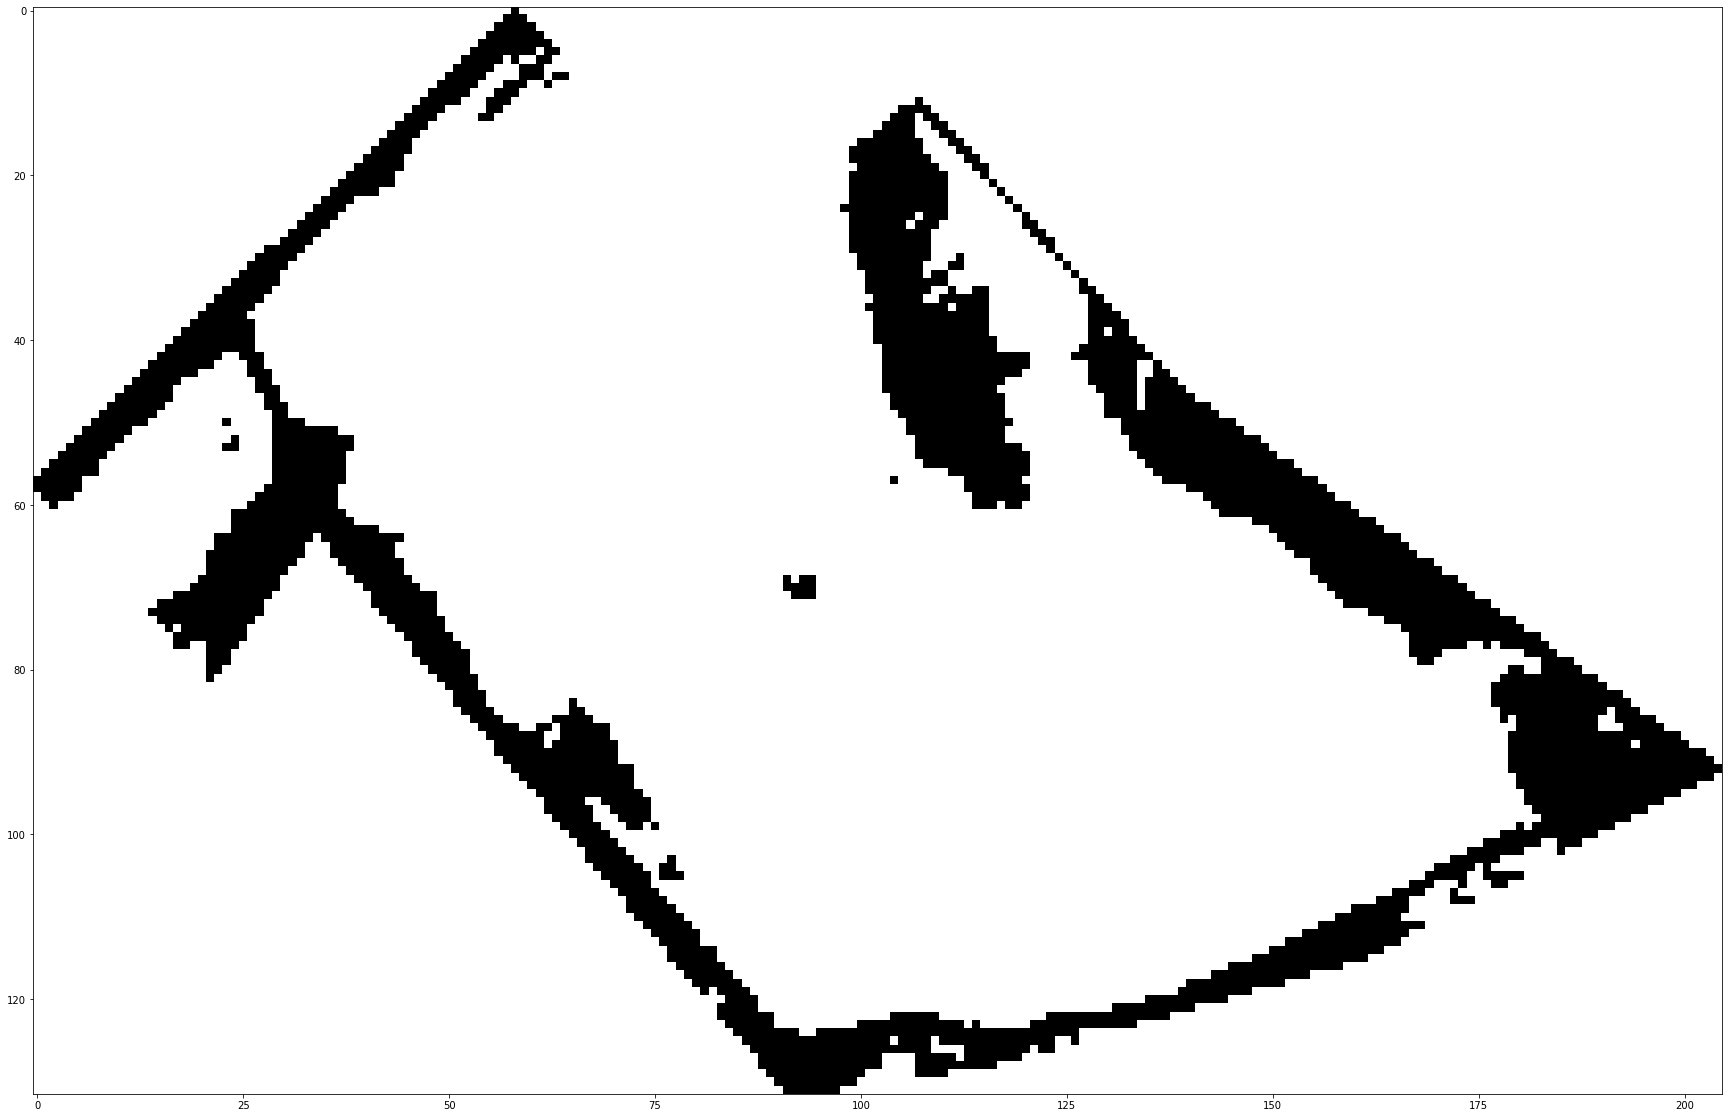

In [ ]:
cultura = plantacoes[2]
imgs = []
pixels_subdesenvolvimento = []
for index, row in cultura.iterrows():
  base_path = 'drive/MyDrive/BEMAGRO/dataset_1/'
  ndvi_path = base_path + row['NDVI']
  dataset = rasterio.open(ndvi_path)
  ndvi = dataset.read()
  imgs.append(ndvi[0])
for l, line in enumerate(imgs[0]):
  for c, ndvi_value in enumerate(line):
    if(ndvi_value >= -1 and ndvi_value < 0.75):
      eh_subdesenvolvido = True
      for img in imgs:
        if img[l][c] >= 0.75:
          eh_subdesenvolvido = False
          break
      if(eh_subdesenvolvido == True):
        pixels_subdesenvolvimento.append((l,c))
print(len(pixels_subdesenvolvimento))
regiao_subdesenvlvimento = np.zeros((imgs[0].shape[0],imgs[0].shape[1])) + 255
for l, c in pixels_subdesenvolvimento:
  regiao_subdesenvlvimento[l][c] = 0

plt.figure(figsize=(80, 20))
plt.imshow(regiao_subdesenvlvimento, cmap="gray")
        
